In [1]:
%load_ext autoreload
%autoreload 2

import dotenv
import os

dotenv.load_dotenv(dotenv_path="secrets.env")
hf_token = os.getenv("HUGGINGFACE_API_KEY")

import os

from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
import dotenv

from tasks.hp.HPTask import HPTriviaTask, HPVerbatimTask, HPVerbatimTaskTranchedByBook
from tasks.hp.HPSAQ import HPSAQ, HPSAQTranchedByBook
from tasks.hp.HPFamiliarity import HPCompletionsFamiliarity, HPFamiliarityTranchedByBook

from datetime import datetime

import tqdm
import torch

import matplotlib.pyplot as plt

/root/hp-unlrn/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_ckpt(base_model, folder, ckpt):
    peft_model = PeftModel.from_pretrained(base_model, os.path.join(folder, "checkpoint-" + str(ckpt)))
    return peft_model

In [3]:
books_to_test_on = [1, 2, 3]

# merge the files "tasks/hp/data/tranched_by_book/book_{book_num}.jsonl" into "tasks/hp/data/tranched_by_book/all.jsonl"

all_data = ""
for book_num in books_to_test_on:
    with open(f"tasks/hp/data/tranched_by_book/book_{book_num}.jsonl", "r") as f:
        all_data += f.read()

with open(f"tasks/hp/data/tranched_by_book/all.jsonl", "w") as f:
    f.write(all_data)

In [4]:
tokenizer = AutoTokenizer.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    use_auth_token=hf_token
)

hp_familiarity_tasks = [HPFamiliarityTranchedByBook(i) for i in books_to_test_on]

hp_verbatim_task = HPVerbatimTaskTranchedByBook(8, tokenizer, books_to_test_on)

def eval_model(model):
    # hp_familiarity_task = HPCompletionsFamiliarity(dataset_path='tasks/hp/data/msr_data/evaluation_prompts.json')
    # exp_time = datetime.now().strftime("%a-%b%-d-%H%M")
    # hp_familiarity_task.generate_responses(model, tokenizer, eval_onthe_fly=True, eval_model='gpt-3.5-turbo', max_new_tokens=20, temperature=0, verbose=True, n_questions=50)
    # familiarity, responses = hp_familiarity_task.get_accuracies()
    # print(responses)
    # return familiarity

    # accs = {"zero_shot": 0, "few_shot": 0, "unrelated_few_shot": 0}
    # for task in hp_saq_tasks:
    #     task.generate_responses(model, tokenizer, n_questions=10)
    #     this_accs = task.get_accuracies()
    #     accs["zero_shot"] += this_accs["zero_shot"]
    #     accs["few_shot"] += this_accs["few_shot"]
    #     accs["unrelated_few_shot"] += this_accs["unrelated_few_shot"]
    
    # accs["zero_shot"] /= len(hp_saq_tasks)
    # accs["few_shot"] /= len(hp_saq_tasks)
    # accs["unrelated_few_shot"] /= len(hp_saq_tasks)

    # return accs

    # score = 0
    # for task in hp_familiarity_tasks:
    #     task.generate_responses(model, tokenizer, eval_model='gpt-4')
    #     familiarity, responses = task.get_accuracies()
    #     score += familiarity
    #     print(responses)
    # score /= len(hp_familiarity_tasks)

    # return score

    #return hp_verbatim_task.get_test_loss(model).item()

    acc = hp_verbatim_task.get_test_loss(model, n_iters=1000).item()
    print(acc)
    return acc

/root/hp-unlrn/.env/lib/python3.10/site-packages/transformers/models/auto/tokenization_auto.py:711: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/root/hp-unlrn/.env/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [5]:
# model_ckpts = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
# model_folders = ["verbatim_finetune"]

# hp_model = AutoModelForCausalLM.from_pretrained(
#     "microsoft/Llama2-7b-WhoIsHarryPotter",
#     use_auth_token=hf_token,
#     torch_dtype=torch.bfloat16
# ).cuda()

# tokenizer.pad_token = tokenizer.eos_token

# hp_acc = eval_model(hp_model)

# all_accuracies = []

# for model_folder in model_folders:
#     accuracies = [(0, hp_acc)]
    
#     for ckpt in model_ckpts:
#         print(ckpt)
#         adapter = load_ckpt(hp_model, model_folder, ckpt)
#         acc = eval_model(hp_model)
#         accuracies.append((ckpt, acc))
#         adapter.unload()
    
#     all_accuracies.append(accuracies)

# del hp_model

# llama_model = AutoModelForCausalLM.from_pretrained(
#     "meta-llama/Llama-2-7b-chat-hf",
#     use_auth_token=hf_token,
#     torch_dtype=torch.bfloat16
# ).cuda()

# base_acc = eval_model(llama_model)

# print(base_acc)
# print(hp_acc)
# print(all_accuracies)

In [6]:
# results from prev run
base_acc_ = 0.46534305908678647
hp_acc_ = 0.32427038263675156
all_accuracies_ = [[(0, 0.32427038263675156), (100, 0.32125954361627784), (200, 0.35320556782193674), (300, 0.3950250996178836), (400, 0.3963737045958042), (500, 0.42296944927665525), (600, 0.49241389372109967), (700, 0.44076731789999557), (800, 0.5259048314673566), (900, 0.4175018492498922), (1000, 0.41718241223961816)]]

In [7]:
base_acc_ = 0.22818220519369947
hp_acc_ = 0.10280970625798212
all_accuracies_ = [[(0, 0.10280970625798212), (100, 0.1336739037888463), (200, 0.09450830140485313), (300, 0.24244359301830565), (400, 0.2220093656875266), (500, 0.15197956577266922), (600, 0.18284376330353344), (700, 0.13154533844189017), (800, 0.09663686675180927), (900, 0.1911451681566624), (1000, 0.12537249893571734)]]

In [8]:
# results on cross-entropy eval (1000 samples from books 4-7)
base_acc = 3.0362651348114014
hp_acc = 3.502548933029175
all_accuracies = [[(0, 3.502548933029175), (100, 3.2807469367980957), (200, 3.0449798107147217), (300, 2.9233744144439697), (400, 2.895801305770874), (500, 2.881465196609497), (600, 2.87931227684021), (700, 2.8763437271118164), (800, 2.8760416507720947), (900, 2.872117757797241), (1000, 2.8754565715789795)]]

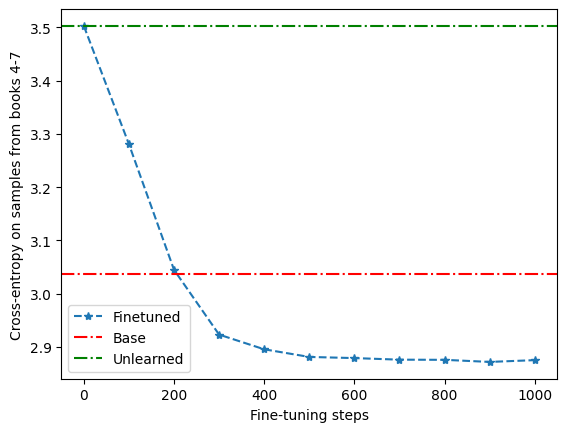

In [9]:
keys = ["zero_shot"]
line_styles = ['--', '-', '-.']

#for y, key in zip(ys, keys):
#    plt.plot(x, y, linestyle="--", marker="*", label="dpo_" + key)

for accs in all_accuracies:
    xs = [ckpt for ckpt, _ in accs]
    ys = [acc for _, acc in accs]
    plt.plot(xs, ys, linestyle="--", marker="*", label="Finetuned")

plt.xlabel('Fine-tuning steps')
plt.ylabel('Cross-entropy on samples from books 4-7')

#for key, line_style in zip(keys, line_styles):
#    plt.axhline(y=base_acc[key], color='r', linestyle=line_style, label="base_" + key)
#    plt.axhline(y=hp_acc[key], color='g', linestyle=line_style, label="unlearned_" + key)

plt.axhline(y=base_acc, color='r', linestyle='-.', label="Base")
plt.axhline(y=hp_acc, color='g', linestyle='-.', label="Unlearned")

plt.legend()
plt.show()

In [10]:
hp_model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Llama2-7b-WhoIsHarryPotter",
    use_auth_token=hf_token,
    torch_dtype=torch.bfloat16
).cuda()

/root/hp-unlrn/.env/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:472: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/root/hp-unlrn/.env/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [15]:
few_shot_counts = [2, 4, 6, 8, 10]
few_shot_accs = []

tokenizer = AutoTokenizer.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    use_auth_token=hf_token
)

tokenizer.pad_token = tokenizer.eos_token

for n in few_shot_counts:
    few_shot_verbatim = HPVerbatimTaskTranchedByBook(8, tokenizer, books_to_test_on, few_shot_num=n)

    with torch.no_grad():
        acc = few_shot_verbatim.get_train_loss(hp_model, n_iters=100).item()
    print(acc)
    few_shot_accs.append(acc)

/root/hp-unlrn/.env/lib/python3.10/site-packages/transformers/models/auto/tokenization_auto.py:711: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/root/hp-unlrn/.env/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.66it/s]


3.54803466796875


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.55it/s]


3.4486536979675293


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.62it/s]


3.4976484775543213


 38%|███████████████████████████████████████                                                                | 3417/9000 [00:03<00:05, 1026.61it/s]


KeyboardInterrupt: 

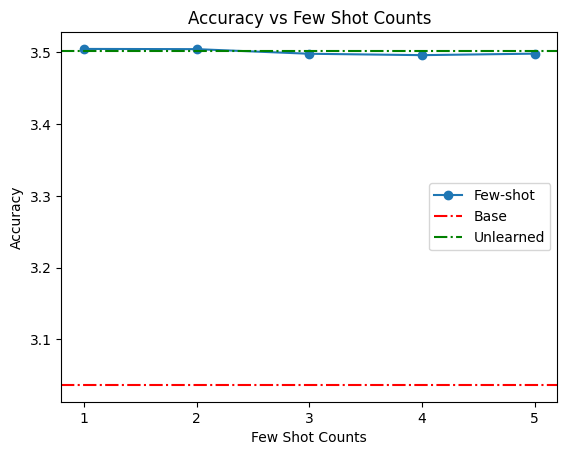

In [14]:
plt.plot(few_shot_counts, few_shot_accs, marker='o', label='Few-shot')

plt.axhline(y=base_acc, color='r', linestyle='-.', label="Base")
plt.axhline(y=hp_acc, color='g', linestyle='-.', label="Unlearned")

plt.xlabel('Few Shot Counts')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Few Shot Counts')
plt.legend()

# Set integer labels on the x-axis
plt.xticks(few_shot_counts, map(str, few_shot_counts))

plt.show()
